In [84]:
import rioxarray as rxr
import numpy as np
from datetime import date
import pandas as pd

In [85]:
def mosaic_monthly(raster_file,year):
    raster_data = rxr.open_rasterio(raster_file)
    date_a = date(2011, 1, 1)
    date_b = date(2020, 1, 1)
    date_c = date(2020, 12, 31)
    # Calculate the difference in days
    days_start=(date_b - date_a).days
    days_end=(date_c-date_a).days
    bands=raster_data[range(days_start,days_end+1)]
    ar_year = np.array([band.values for band in bands])
    mo_year=[]
    start_index=0
    end_index=0
    for i in range(0,12):
        dt_start=date(2020,i+1,1)
        if i<11:
            dt_end=date(2020,i+2,1)
        else:
            dt_end=date(2021,1,1)
        days=(dt_start-dt_end).days
        end_index=start_index+days+1
        mosaic_months=ar_year[start_index:end_index+1,:,:].mean(axis=0)
        mo_year.append(mosaic_months)
        start_index=end_index
    return np.array(mo_year)

In [86]:
ch_mosaic=mosaic_monthly('Curah_Hujan.tif',2020)

C:\Users\achmf\AppData\Local\Temp\ipykernel_8724\50163137.py:22: RuntimeWarning: Mean of empty slice.
  mosaic_months=ar_year[start_index:end_index+1,:,:].mean(axis=0)
C:\Users\achmf\.conda\envs\mlenv\lib\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


In [87]:
rh_mosaic=mosaic_monthly('RH.tif',2020)

C:\Users\achmf\AppData\Local\Temp\ipykernel_8724\50163137.py:22: RuntimeWarning: Mean of empty slice.
  mosaic_months=ar_year[start_index:end_index+1,:,:].mean(axis=0)
C:\Users\achmf\.conda\envs\mlenv\lib\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


In [88]:
t_mosaic=mosaic_monthly('TEMPERATUR.tif',2020)

C:\Users\achmf\AppData\Local\Temp\ipykernel_8724\50163137.py:22: RuntimeWarning: Mean of empty slice.
  mosaic_months=ar_year[start_index:end_index+1,:,:].mean(axis=0)
C:\Users\achmf\.conda\envs\mlenv\lib\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


In [99]:
tif_path = 'NDVI_11_24.tif'
raster = rxr.open_rasterio(tif_path)
# Convert the raster data into a NumPy array
ndvi_mosaic = raster.values

tif_path = 'PDSI.tif'
raster = rxr.open_rasterio(tif_path)
# Convert the raster data into a NumPy array
pdsi_mosaic = raster.values

print(ndvi_mosaic.shape)

(12, 38, 50)


In [100]:
dt_gab=np.array([ch_mosaic,rh_mosaic,t_mosaic,ndvi_mosaic,pdsi_mosaic])

In [108]:
dict_df={}
for i in range(0,dt_gab.shape[0]):
    dict_df[i]=dt_gab[i,:,:,:].ravel()

In [109]:
data_=pd.DataFrame(dict_df)

In [110]:
data_.columns=['ch','rh','t','ndvi','pdsi']
data_['ndvi'].replace(0,-9999,inplace=True)
data_['ndvi'].replace(-9999,np.nan,inplace=True)

data_['pdsi'].replace(0,-9999,inplace=True)
data_['pdsi'].replace(-9999,np.nan,inplace=True)
data_['ch'].replace(-9999,np.nan,inplace=True)
data_['rh'].replace(-9999,np.nan,inplace=True)
data_['t'].replace(-9999,np.nan,inplace=True)

In [111]:
data_.dropna(inplace=True)

In [112]:
data_['ndvi']=data_.ndvi*0.0001
data_['pdsi']=data_.pdsi*0.01

In [113]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [114]:
data_

,ch,rh,t,ndvi,pdsi
64,5.770989,-4507.139466,28.668152,-0.045118,-4.023552
65,5.522403,-4519.694362,28.683402,0.022746,-4.071099
114,5.917768,-4481.083086,28.664305,0.161352,-3.926659
115,5.804349,-4491.172107,28.707260,0.221455,-3.993086
116,5.536375,-4501.305638,28.595351,0.122628,-4.033929
...,...,...,...,...,...
1889,9.682652,-2883.071217,26.968733,0.804652,-1.705578
1890,9.592973,-2994.284866,27.067359,0.776218,-1.673131
1891,9.235468,-3105.468843,27.191014,0.765537,-1.666780
1892,9.041769,-3216.682493,27.281745,0.808540,-2.058445


[[-0.925466   -1.10956628  1.53768174 -3.56385374]
 [-1.01298636 -1.12204088  1.54470739 -3.18051854]]


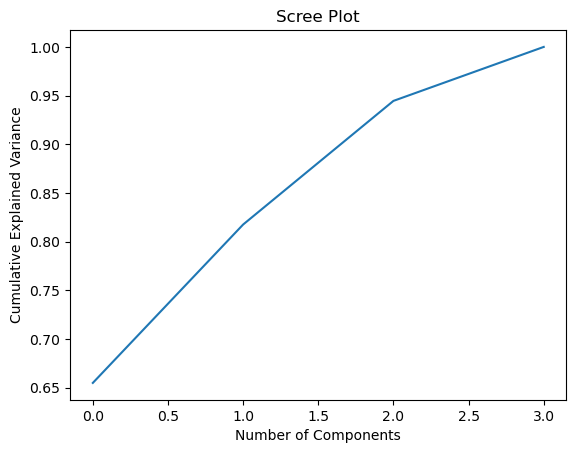

In [115]:
# Normalize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_[['ch','rh','t','ndvi']])
print(data_scaled[0:2,:])

# Apply PCA
pca = PCA()
pca.fit(data_scaled)

# Create scree plot
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.show()

In [116]:
pca = PCA(n_components=2)  # Reduce to one dimension

# Fit and transform the data
X_reduced = pca.fit_transform(data_scaled)

print(X_reduced)

[[ 3.56708089 -0.21070556]
 [ 3.42410679 -0.1779093 ]
 [ 2.94229481  0.08080407]
 ...
 [-0.39154619  0.94747464]
 [-0.40081661  1.00329996]
 [-0.1269756   1.10201153]]


In [119]:
data_['PC1']=X_reduced[:,0]
data_['PC2']=X_reduced[:,1]

In [130]:
#import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.model_selection import train_test_split


X, y = data_[['PC1','PC2']], data_['pdsi']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

gb_reg = GradientBoostingRegressor()

# Define parameter grid for cross-validation
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [3, 4, 5]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(gb_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X, y)

# Print best parameters and cross-validation score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", -grid_search.best_score_) 

Best parameters: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 100}
Best cross-validation score: 0.8018448469562044
